In [4]:
import os, cv2, math
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import numpy as np
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from shutil import copyfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [ ]:
import os

def rename_alphabet_files(directory):
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith("_test.jpg"):
            # Get the file path
            old_path = os.path.join(directory, filename)

            # Extract the alphabet character (assuming it's the first character before '_test.jpg')
            alphabet_char = filename[0]

            # Form the new filename
            new_filename = f"example_{alphabet_char}.JPG"
            new_path = os.path.join(directory, new_filename)

            # Rename the file
            os.rename(old_path, new_path)

            print(f"Renamed: {filename} -> {new_filename}")

# Provide the directory path where the files are located

directory_path = "Sign-Language-Digits-Dataset/Examples/"

# Call the function to rename alphabet files
rename_alphabet_files(directory_path)

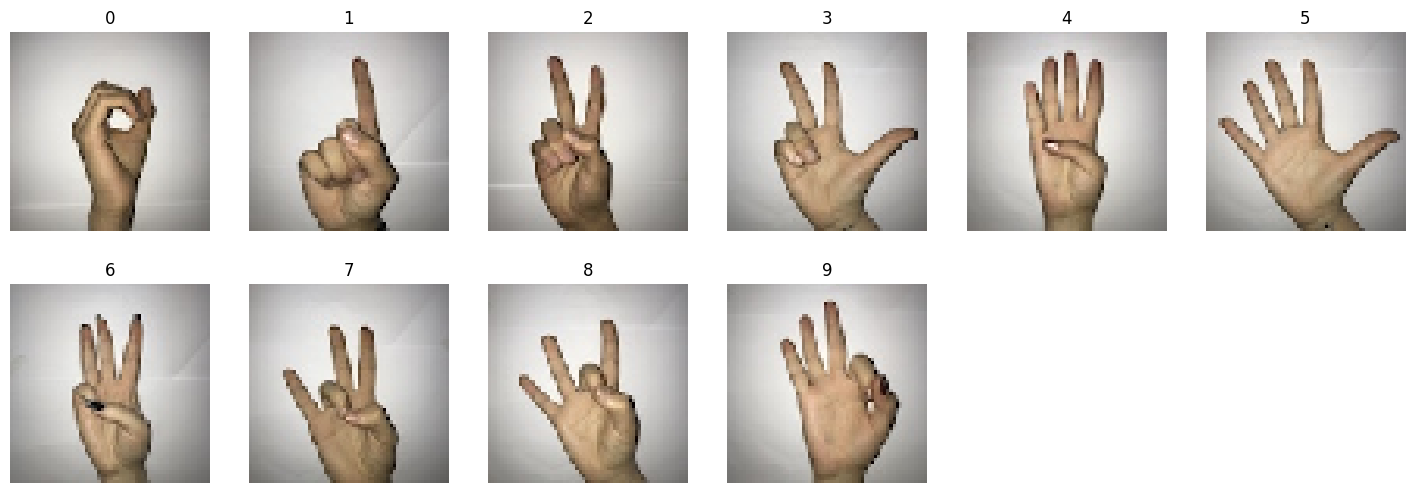

In [35]:
try:
    import string
    nrow, ncol = 2, 6
    plt.rcParams['figure.figsize'] = (ncol*3, nrow*3)
    for row in range(nrow):
        for col in range(ncol):
            img_index = row*ncol+col
            # load image
            img = image.load_img('Sign-Language-Digits-Dataset/Examples/example_' + str(img_index) + '.JPG', target_size = (64, 64))
            plt.subplot(nrow, ncol, img_index + 1)
            plt.imshow(img)
            plt.title(img_index)
            plt.axis('off')



    
except Exception as e:
    pass        

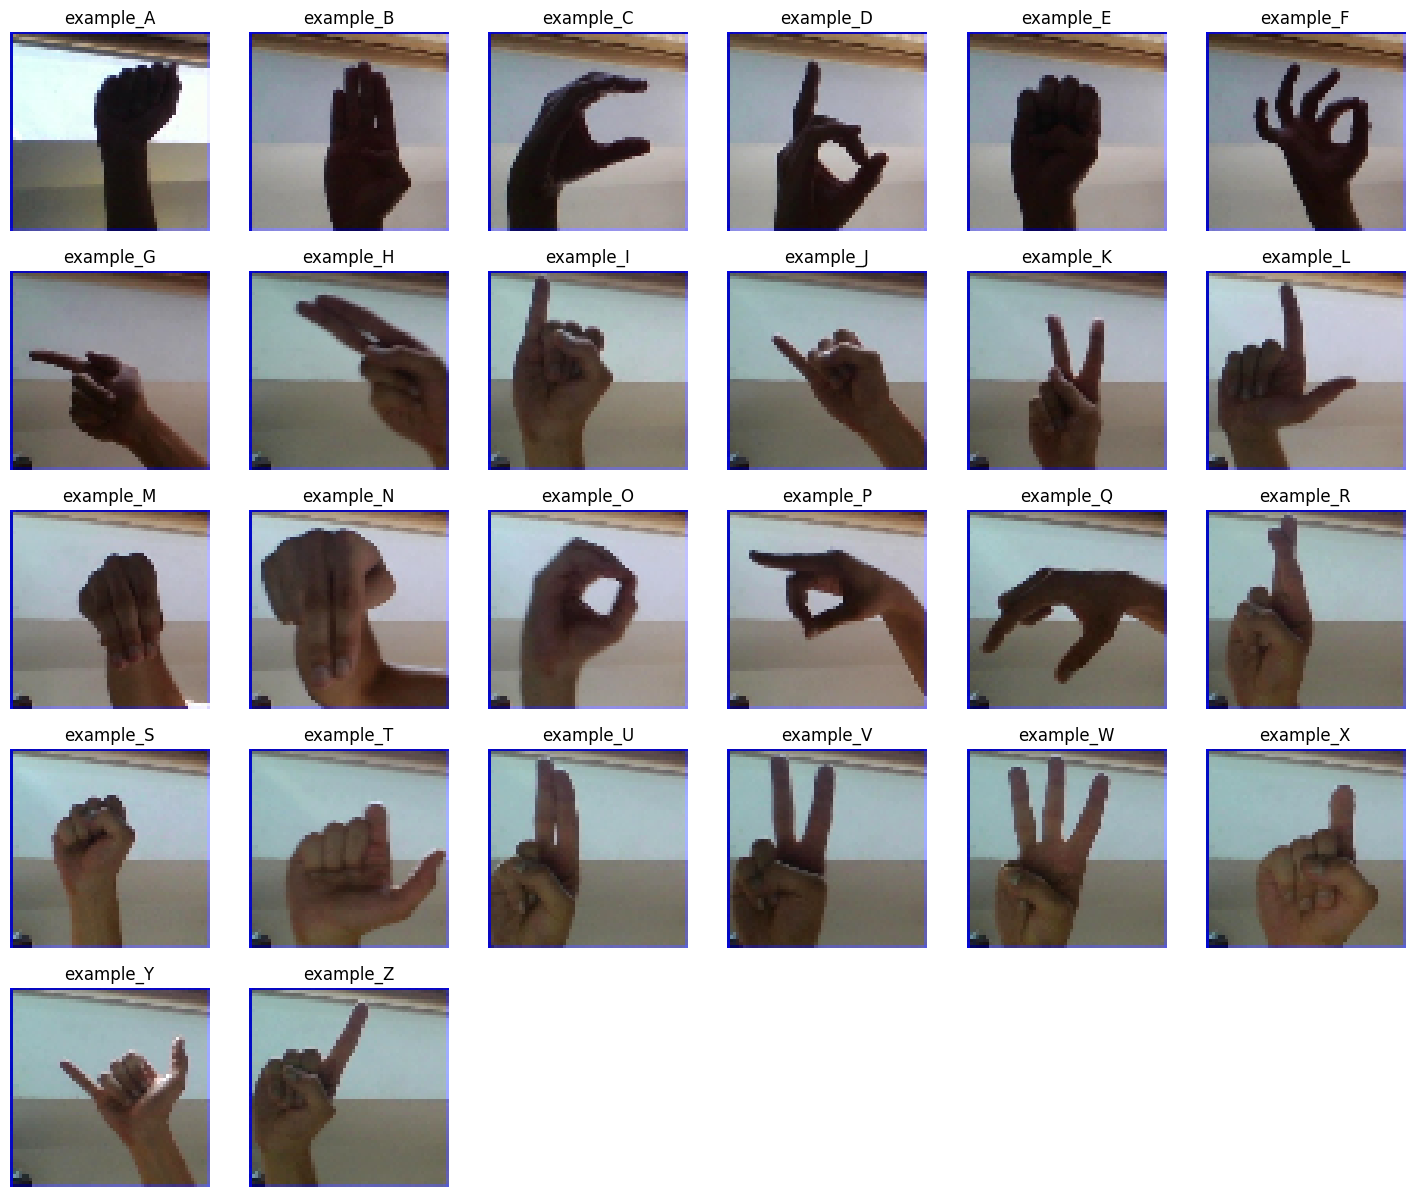

In [36]:
try:  
    import os
    from keras.preprocessing import image
    import matplotlib.pyplot as plt
    def show_alphabets(directory_path, prefix, nrow, ncol):
        plt.rcParams['figure.figsize'] = (ncol * 3, nrow * 3)
        for row in range(nrow):
            for col in range(ncol):
                img_index = row * ncol + col
                # Load image
                img_path = os.path.join(directory_path, f'{prefix}_{chr(ord("A") + img_index)}.JPG')
                img = image.load_img(img_path, target_size=(64, 64))
                plt.subplot(nrow, ncol, img_index + 1)
                plt.imshow(img)
                plt.title(f'{prefix}_{chr(ord("A") + img_index)}')
                plt.axis('off')

    # Specify the directory path
    directory_path = 'Sign-Language-Digits-Dataset/Examples'

    # Show alphabets
    show_alphabets(directory_path, 'example', 5, 6)
    plt.show()
except Exception as e:
    pass

In [37]:
DATASET_PATH = 'Sign-Language-Digits-Dataset/Dataset/'

In [38]:
# Creating a list of filename for training set, validation set, and test set
train_set = {}
validation_set = {}
test_set = {}
for cat in os.listdir(DATASET_PATH):
  cat_dir = os.path.join(DATASET_PATH, cat) # e.g. DATASET_PATH/'0'
  cat_files = os.listdir(cat_dir)
  # Training set's size is 70% of the data
  train_list , test_list = train_test_split(cat_files, test_size = 0.3)
  # Validation set's and Test set's size are both 15% of the data
  validation_list, test_list = train_test_split(test_list, test_size = 0.5)
  train_set[cat] = train_list
  validation_set[cat] = validation_list
  test_set[cat] = test_list

In [39]:
for cat in tqdm(train_set.keys()):
  cat_dir = os.path.join(DATASET_PATH, 'training_set', 'class_0' + str(cat))
  os.makedirs(cat_dir)
  for file in train_set[cat]:
    # src path is DATASET_PATH/'0'/file
    src = os.path.join(DATASET_PATH, cat, file)
    # dest path is DATASET_PATH/'training_set'/'class_00'
    # to accomodate for the directory format required by flow_from_directory method in keras
    dest = os.path.join(cat_dir, file)
    copyfile(src, dest)

100%|██████████| 39/39 [32:54<00:00, 50.62s/it] 


In [21]:
import string
import numpy as np
dig = list(np.arange(10))

alpha= list(string.ascii_uppercase)


char = dig + alpha


In [26]:
j=np.array(char)
j

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U11')

In [32]:
from func import *
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
label_map = {label:num for num, label in enumerate(actions)}
# print(label_map)
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,63)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
res = [.7, 0.2, 0.1]

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])
model.summary()

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save('model.h5')

NameError: name 'audio_classifier' is not defined